In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import random
import scipy.stats as stats
from scipy import special
import math
import random
import os 

Z = stats.norm.ppf
rng = np.random.default_rng()

In [3]:
Dir_project = '/work/desai-lab/xuanyang/Project/TwoWordTest/'
df_raw = pd.read_csv('/work/desai-lab/xuanyang/Project/TwoWordTest/codes/Stim_2160_shuffle10.csv')
# df_raw = df_raw.loc[df_raw.shuffleID!=0]

df_raw

,Idx,promptID,idxInPrompt,Stim,shuffleID,shuffleSeed,rand
0,1,1,1,the truck police.,1,3583.0,0.000215
1,2,1,2,the cage rib.,1,3583.0,0.000287
2,3,1,3,the holiday summer.,1,3583.0,0.000488
3,4,1,4,the soap bottle.,1,3583.0,0.001347
4,5,1,5,the radio prison.,1,3583.0,0.001542
...,...,...,...,...,...,...,...
21595,2156,8,159,the goat cheese.,0,NaN,NaN
21596,2157,8,160,the sand beach.,0,NaN,NaN
21597,2158,8,161,the mouth pig.,0,NaN,NaN
21598,2159,8,162,the field flower.,0,NaN,NaN


In [6]:
def get_gemini_ratings(Dir_project,df_models):

    mapping_rating = {'nonsense':0, 'makes sense':1, 'nonsense ':0, 'makes sense ':1,
           'macht sense':1, 'macht Sinn':1, 'maakt sense':1, 'nonsens':0}
    dfs = []
    dfs_output_all = []
    for i,row in df_models.iterrows():
        model_name,model_label,rating_type = row[['model','label','rating_type']]
        Dir_output = os.path.join(Dir_project,'results',rating_type,model_name)
        dfs_output = []
        for idx in range(10):
            df_output = []
            for promptID in range(1,9):
                if promptID in [2,8]:
                    output_txt = os.path.join(Dir_output,f'{model_name}_{rating_type}_shuffle{idx}_prompt{promptID}.txt')
                    with open(output_txt) as f:
                        lines_raw = f.readlines()

                else:
                    output_txt1 = os.path.join(Dir_output,f'{model_name}_{rating_type}_shuffle{idx}_prompt{promptID}1.txt')
                    with open(output_txt1) as f:
                        lines_raw1 = f.readlines()
                    output_txt2 = os.path.join(Dir_output,f'{model_name}_{rating_type}_shuffle{idx}_prompt{promptID}2.txt')
                    with open(output_txt2) as f:
                        lines_raw2 = f.readlines()
                    lines_raw = lines_raw1+lines_raw2

                for text in lines_raw:
                    text = text.replace('\n','').replace('- ','').replace('*','')
                    df_output.append(pd.DataFrame({'words':text.split(': ')[0],'rating':text.split(': ')[1],
                                              'promptID':promptID,
                                               'iteration':idx},index=[0]))

            df_output = pd.concat(df_output,ignore_index=True)
            df_output['id'] = list(range(len(df_output)))
            dfs_output.append(df_output)
        dfs_output = pd.concat(dfs_output,ignore_index=True)

        if rating_type == 'continuous':
            dfs_output['rating'] = dfs_output['rating'].str.replace('.','').str.replace(' ','').astype(int)
        else:
            dfs_output['words'] = dfs_output['words'].str.replace('.','')
            dfs_output['words'] = dfs_output['words'].str.replace('harbor','harbour')
            dfs_output['rating'] = dfs_output['rating'].map(mapping_rating)

        dfs_output['model'] = f'{model_label}_{rating_type}'

        dfs_output_all.append(dfs_output)
        df = dfs_output.groupby(['words','model']).mean().reset_index()
        dfs_output.groupby(['words']).count()
        df = df[['words','rating']]

        df.columns=['Stim','rating']
        df['N_counts'] = dfs_output.groupby(['words']).count()['rating'].values
        df['model'] = f'{model_label}_{rating_type}'
        dfs.append(df)
    dfs = pd.concat(dfs,ignore_index=True)
    dfs_output_all = pd.concat(dfs_output_all,ignore_index=True)
    return dfs,dfs_output_all

In [7]:
def get_claude_ratings(Dir_project,df_models):
    mapping_rating = {'makes sense':1,'nonsense':0}
    dfs = []
    dfs_output_all = []

    for i,row in df_models.iterrows():
        model_name,model_label,rating_type = row[['model','label','rating_type']]
        Dir_output = os.path.join(Dir_project,'results',rating_type,model_name)
        dfs_output = []

        for idx in range(10):
            df_output = []
            for promptID in range(1,9):
                output_txt = os.path.join(Dir_output,f'{model_name}_{rating_type}_shuffle{idx}_prompt{promptID}.txt')
                if os.path.exists(output_txt):
                    with open(output_txt) as f:
                        lines_raw = f.readlines()

                    for text in lines_raw:
                        text = text.replace('\n','').replace('- ','').replace('*','').replace('.','')
                        if ':' in text and text.endswith(':')!=True:
                            df_output.append(pd.DataFrame({'words':text.split(': ')[0],'rating':text.split(': ')[1],
                                                      'promptID':promptID,
                                                       'iteration':idx},index=[0]))

            if len(df_output)!=0:
                df_output = pd.concat(df_output,ignore_index=True)
                df_output['id'] = list(range(len(df_output)))

                dfs_output.append(df_output)

        dfs_output = pd.concat(dfs_output,ignore_index=True)

        if rating_type == 'continuous':
            dfs_output['rating'] = dfs_output['rating'].str.split(' ',expand=True)[0].astype(int)
        else:
            dfs_output['rating'] = dfs_output['rating'].map(mapping_rating)

        dfs_output['model'] = f'{model_label}_{rating_type}'

        dfs_output_all.append(dfs_output)
        df = dfs_output.groupby(['words','model']).mean().reset_index()
        dfs_output.groupby(['words']).count()
        df = df[['words','rating']]

        df.columns=['Stim','rating']
        df['N_counts'] = dfs_output.groupby(['words']).count()['rating'].values
        df['model'] = f'{model_label}_{rating_type}'
        dfs.append(df)
    dfs = pd.concat(dfs,ignore_index=True)
    dfs_output_all = pd.concat(dfs_output_all,ignore_index=True)
    return dfs,dfs_output_all



In [9]:
def get_GPT_ratings(Dir_project,List_models):
    mapping_rating = {'makes sense':1,'nonsense':0}


    dfs = []
    dfs_output_all = []
    for i,row in df_models.iterrows():
        model_name,model_label,rating_type = row[['model','label','rating_type']]
        Dir_output = os.path.join(Dir_project,'results',rating_type,model_name)
        dfs_output = []
        for idx in range(10):
            df_output = []
            for promptID in range(1,9):

                output_txt = os.path.join(Dir_output,f'{model_name}_{rating_type}_shuffle{idx}_prompt{promptID}.txt')
                with open(output_txt) as f:
                    lines_raw = f.readlines()

                for text in lines_raw:
                    text = text.replace('\n','').replace('- ','').replace('*','')
                    df_output.append(pd.DataFrame({'words':text.split(': ')[0],'rating':text.split(': ')[1],
                                              'promptID':promptID,
                                               'iteration':idx},index=[0]))

            df_output = pd.concat(df_output,ignore_index=True)
            df_output['id'] = list(range(len(df_output)))
            dfs_output.append(df_output)
        dfs_output = pd.concat(dfs_output,ignore_index=True)

        if rating_type == 'continuous':
            dfs_output['rating'] = dfs_output['rating'].str.split(' ',expand=True)[0].astype(int)
        else:
            dfs_output['words'] = dfs_output['words'].str.replace('.','')
            dfs_output['words'] = dfs_output['words'].str.replace('harbor','harbour')
            dfs_output['rating'] = dfs_output['rating'].map(mapping_rating)

        dfs_output['model'] = f'{model_label}_{rating_type}'

        dfs_output_all.append(dfs_output)
        df = dfs_output.groupby(['words','model']).mean().reset_index()
        dfs_output.groupby(['words']).count()
        df = df[['words','rating']]

        df.columns=['Stim','rating']
        df['N_counts'] = dfs_output.groupby(['words']).count()['rating'].values
        df['model'] = f'{model_label}_{rating_type}'
        dfs.append(df)
    dfs = pd.concat(dfs,ignore_index=True)
    dfs_output_all = pd.concat(dfs_output_all,ignore_index=True)
    return dfs,dfs_output_all

In [10]:
""" Chi Squared Test

Run Chi Squared Test which compares the expected frequency of responses (human), to the observed (LLMs)

NOTE: a non-significant Chi Squared does not necessarily mean that the LLM is correctly classifying phrases,
it only means that the frequency of responses of the LLM closely matches humans
"""

def ChiSquareLoop(df, models_list):
    fexp = df['Humans_Discrete'].value_counts()
    
    for model in models_list:
        fobs = df[model].value_counts()
        
        chi = stats.chisquare(f_obs=[fobs[0], fobs[1]], f_exp=[fexp[0],fexp[1]])
        
        print('Results for ', model)
        print(fobs)
        print(chi)
        print('################')

In [11]:
df_models = pd.DataFrame({'model':['gemini-1.0-pro-001','gemini-1.0-pro-001'],
                          'label':'gemini',
                          'rating_type':['continuous','discrete']})
dfs_gemini,dfs_output_all = get_gemini_ratings(Dir_project,df_models)
dfs_gemini

,Stim,rating,N_counts,model
0,the alcohol blood,2.3,10,gemini_continuous
1,the alcohol screen,2.8,10,gemini_continuous
2,the alligator mouth,3.7,10,gemini_continuous
3,the alligator skin,3.8,10,gemini_continuous
4,the ankle bracelet,4.0,10,gemini_continuous
...,...,...,...,...
4315,the worm farmer,1.0,10,gemini_discrete
4316,the yarn ball,1.0,10,gemini_discrete
4317,the zebra skin,0.9,10,gemini_discrete
4318,the zipper teeth,0.8,10,gemini_discrete


In [12]:
df_models = pd.DataFrame({'model':['claude-3-opus-20240229','claude-3-opus-20240229'],
                          'label':'claude',
                          'rating_type':['continuous','discrete']})
dfs_claude,dfs_output_all = get_claude_ratings(Dir_project,df_models)
dfs_claude

,Stim,rating,N_counts,model
0,the alcohol blood,3.0,10,claude_continuous
1,the alcohol screen,1.0,10,claude_continuous
2,the alligator mouth,3.7,10,claude_continuous
3,the alligator skin,3.3,10,claude_continuous
4,the ankle bracelet,3.8,10,claude_continuous
...,...,...,...,...
4315,the worm farmer,0.4,10,claude_discrete
4316,the yarn ball,1.0,10,claude_discrete
4317,the zebra skin,1.0,10,claude_discrete
4318,the zipper teeth,1.0,10,claude_discrete


In [13]:
df_models = pd.DataFrame({'model':['gpt-4-1106-preview','gpt-4-1106-preview','gpt-4-0125-preview','gpt-4-0125-preview',
                                   'gpt-3.5-turbo-1106','gpt-3.5-turbo-1106','gpt-3.5-turbo-0125','gpt-3.5-turbo-0125'],
                          'label':['gpt-4-1106','gpt-4-1106','gpt-4-0125','gpt-4-0125',
                                   'gpt-3.5-1106','gpt-3.5-1106','gpt-3.5-0125','gpt-3.5-0125'],
                          'rating_type':['continuous','discrete','continuous','discrete',
                                         'continuous','discrete','continuous','discrete']})
dfs_gpt,dfs_output_all = get_GPT_ratings(Dir_project,df_models)
dfs_gpt

,Stim,rating,N_counts,model
0,the alcohol blood,2.5,10,gpt-4-1106_continuous
1,the alcohol screen,1.2,10,gpt-4-1106_continuous
2,the alligator mouth,2.5,10,gpt-4-1106_continuous
3,the alligator skin,3.3,10,gpt-4-1106_continuous
4,the ankle bracelet,3.9,10,gpt-4-1106_continuous
...,...,...,...,...
17275,the worm farmer,1.0,10,gpt-3.5-0125_discrete
17276,the yarn ball,0.9,10,gpt-3.5-0125_discrete
17277,the zebra skin,1.0,10,gpt-3.5-0125_discrete
17278,the zipper teeth,1.0,10,gpt-3.5-0125_discrete


In [14]:
def get_CI(data_mean,data_std,n,confidence):

    df = n - 1

    t_crit = stats.t.ppf((1 + confidence) / 2, df)

    ci_lower = data_mean - t_crit * data_std/np.sqrt(n)
    ci_upper = data_mean + t_crit * data_std/np.sqrt(n)
    return ci_lower, ci_upper

def set_CI(df_data,n=150):
    df_data['sensible'] = np.nan
    for i,row in df_data.iterrows():
        Mean, Std = row[['Humans Continuous','SD']]
        ci_lower, ci_upper = get_CI(Mean,Std,n,.95)
        if (ci_lower >=1.5) & (Mean >=2.5):
            df_data.loc[i,'sensible'] = 1

        if (ci_upper <=2.5) & (Mean <=1.5):    
            df_data.loc[i,'sensible'] = 0
    return df_data

### Combine the Human ratings with LLM ratings

In [40]:
df_AI = pd.concat([dfs_gpt,dfs_gemini,dfs_claude],ignore_index=True)
df_AI = df_AI.pivot(index='Stim',columns='model',values='rating').reset_index().rename_axis(None, axis=1)
graves = pd.read_csv(os.path.join(Dir_project,'codes','graves_2013.csv'))
LLM = pd.read_csv(os.path.join(Dir_project,'codes','LLM_ratings.csv'))
graves = graves.merge(LLM,on='Stim',how='inner')
graves.Stim = graves.Stim.str.replace('.','')

df_data = graves.merge(df_AI,on='Stim',how='inner')
df_data['Humans_discrete'] =     np.where(
                        df_data['Humans Continuous'] >= 2.5, 'Makes Sense', np.where(
                        df_data['Humans Continuous'] <= 1.5, 'Nonsense', 'NA'))
set_CI(df_data)
df_data

,Stim,Humans Continuous,SD,Word2Vec,GloVe,Taxonomic,Bard,Bard 0 or 1,Bard Continuous,GPT-3.5,...,gpt-3.5-0125_continuous,gpt-3.5-0125_discrete,gpt-3.5-1106_continuous,gpt-3.5-1106_discrete,gpt-4-0125_continuous,gpt-4-0125_discrete,gpt-4-1106_continuous,gpt-4-1106_discrete,Humans_discrete,sensible
0,the alcohol blood,0.71,0.98,0.371276,0.402202,0.570252,Nonsense,0,2,Nonsense,...,3.300,0.7,3.800000,0.9,1.8,0.700000,2.5,0.5,Nonsense,0.0
1,the alcohol screen,0.90,1.18,0.066408,0.079153,0.174365,Nonsense,0,1,Makes Sense,...,3.000,1.0,3.111111,0.9,1.3,0.111111,1.2,0.1,Nonsense,0.0
2,the alligator mouth,3.54,0.96,0.212631,0.283078,0.205588,Makes Sense,1,2,Nonsense,...,2.900,1.0,3.400000,1.0,2.2,0.700000,2.5,0.8,Makes Sense,1.0
3,the alligator skin,3.93,0.26,0.150999,0.284452,0.227702,Nonsense,0,3,Makes Sense,...,3.100,1.0,3.700000,1.0,3.0,1.000000,3.3,1.0,Makes Sense,1.0
4,the ankle bracelet,4.00,0.00,0.158441,0.392702,0.263679,Nonsense,0,3,Makes Sense,...,2.700,1.0,3.300000,1.0,4.0,1.000000,3.9,1.0,Makes Sense,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1763,the woman judge,3.64,0.78,0.279547,0.290409,0.280588,Makes Sense,1,4,Makes Sense,...,3.100,1.0,3.400000,1.0,3.8,1.000000,4.0,1.0,Makes Sense,1.0
1764,the woman mountain,0.43,0.74,0.117146,0.187664,0.175159,Nonsense,0,3,Nonsense,...,2.875,1.0,2.900000,1.0,1.6,0.200000,1.5,0.0,Nonsense,0.0
1765,the worm farmer,2.50,1.62,0.118636,0.056309,0.270838,Nonsense,0,2,Makes Sense,...,3.100,1.0,3.700000,1.0,1.6,0.500000,1.6,0.1,Makes Sense,1.0
1766,the yarn ball,3.59,0.98,0.093765,0.204294,0.390770,Nonsense,0,3,Makes Sense,...,3.100,0.9,3.555556,0.9,3.9,1.000000,4.0,1.0,Makes Sense,1.0


In [20]:
List_models_continuous = ['Humans Continuous','claude_continuous','gemini_continuous',
                      'gpt-3.5-1106_continuous','gpt-3.5-0125_continuous','gpt-4-1106_continuous','gpt-4-0125_continuous']

List_models_continuous

['Humans Continuous',
 'claude_continuous',
 'gemini_continuous',
 'gpt-3.5-1106_continuous',
 'gpt-3.5-0125_continuous',
 'gpt-4-1106_continuous',
 'gpt-4-0125_continuous']

In [21]:
df_models = pd.DataFrame({'model':['Humans Continuous','claude_continuous','gemini_continuous',
                      'gpt-3.5-1106_continuous','gpt-3.5-0125_continuous','gpt-4-1106_continuous','gpt-4-0125_continuous'],
                          'label':['Humans','claude-3-opus','gemini-1.0-pro-001','gpt-3.5-1106','gpt-3.5-turbo','gpt-4-1106','gpt-4-turbo'],
                         'color':['#B73333','#C69676','#4F82CB','#BFFFB8','#80FF72','#86CEBD','#0F9E78'],
                          
                         'alpha':[0.6,0.6,0.6,0.4,0.8,0.4,0.6]})
df_models = df_models.loc[~df_models.label.str.contains('1106')].reset_index(drop=True)
df_models

,model,label,color,alpha
0,Humans Continuous,Humans,#B73333,0.6
1,claude_continuous,claude-3-opus,#C69676,0.6
2,gemini_continuous,gemini-1.0-pro-001,#4F82CB,0.6
3,gpt-3.5-0125_continuous,gpt-3.5-turbo,#80FF72,0.8
4,gpt-4-0125_continuous,gpt-4-turbo,#0F9E78,0.6


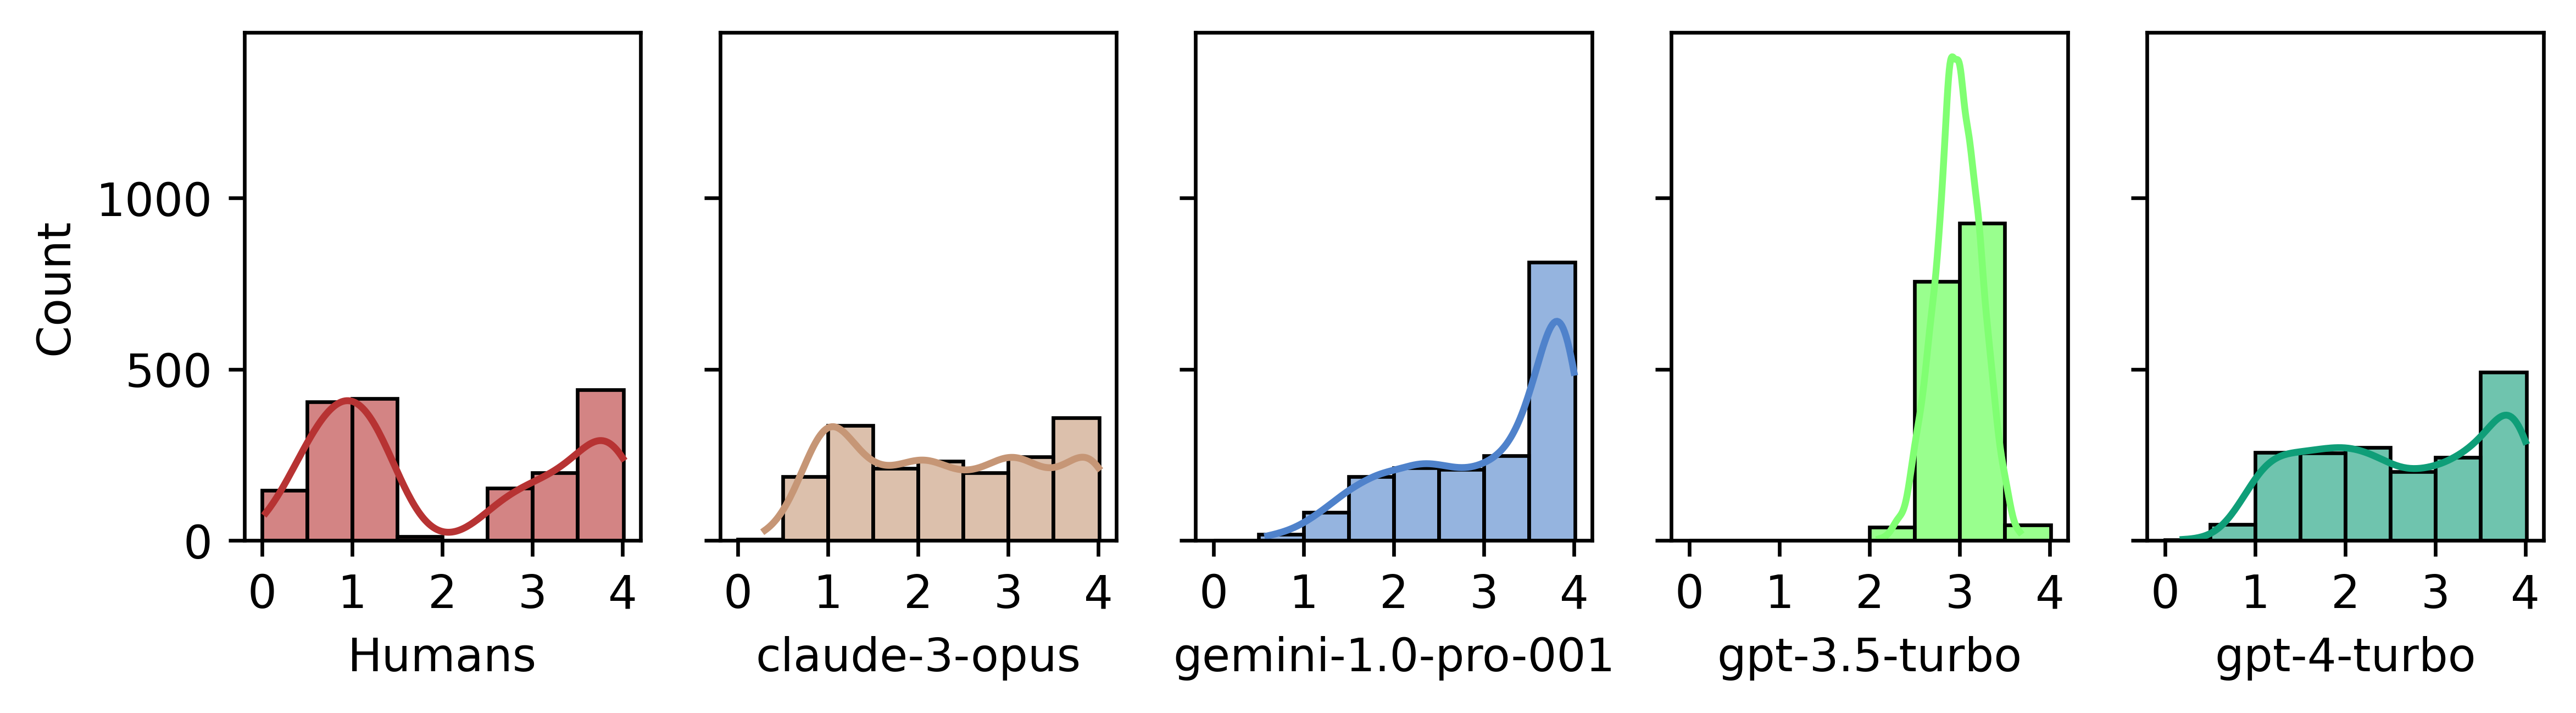

In [22]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


fig,axes = plt.subplots(nrows = 1,ncols = 5,figsize=(9,2),sharex=True,sharey='row',dpi=600)
bin_edges = np.arange(0, 4.5, 0.5)
bin_edges[-1]=4.01
# bin_edges[3]=1.51
for i,row in df_models.iterrows():
    hatch = '/' if 'gpt-3.5' in row['model'] else None
    sns.histplot(df_data,x=row['model'],bins=bin_edges, color=row['color'],
                 linewidth = 0.8,
                 alpha=row['alpha'],ax=axes[i],kde=True)
    axes[i].set(xlabel=row['label'],xlim=[-0.2,4.2])
    axes[i].set_xticks(range(5), labels=range(5))
    for line in axes[i].get_lines():
        line.set_alpha(1)
    
plt.show()
fig.savefig(os.path.join(Dir_project,'results','figures','Fig1.jpg'),bbox_inches='tight')

In [24]:
""" Generate Distributions

This function uses the original means and standard deviations of the Graves 2013 data to simulate
an N-sized response distribution for each phrase

That is, if N human participants rated these phrases, what type of distribution could we expect?

We will use these distributions later to test 'cases' (LLMs) against the 'controls' (human response distribution)

This will identify 'outlier' cases that are highly unlikely to belong to the human distribution, i.e.,
phrases where the LLMs fail to rate meaningfulness in a way that resembles human conceptions of meaningfulness

Simulated Distribution = generated phrase-wise human response distribution that we can use for bootstrapping

Permuted Distribution = randomly selected (phrase-wise) 0-4 integers, based on probability of 0, 1, 2, 3, 4 mean responses
of entire dataset (i.e., round the mean values from original Graves dset, calculate the proportion of each answer)

"""

def GenerateDistributions(df, N=10000):
    min_value = 0
    max_value = 4
    df['Simulated Distribution'] = ''
    df['Permuted Distribution'] = ''
    
    for index, row in df.iterrows():
        mean = row['Humans Continuous']
        std = row['SD']
        
        if std == 0:
            min_in_standard_domain = (min_value - mean)
            max_in_standard_domain = (max_value - mean)
        else:
            min_in_standard_domain = (min_value - mean) / std
            max_in_standard_domain = (max_value - mean) / std
    
        min_in_erf_domain = special.erf(min_in_standard_domain)
        max_in_erf_domain = special.erf(max_in_standard_domain)
        np.random.seed(seed=123)
        random_uniform_data = np.random.uniform(min_in_erf_domain, max_in_erf_domain, N)
        random_gaussianized_data = (special.erfinv(random_uniform_data) * std) + mean
    
#         random_gaussianized_data = np.around(random_gaussianized_data,0)
    
        df.at[index, 'Simulated Distribution'] = random_gaussianized_data
        df.at[index, 'Permuted Distribution'] = np.random.choice(5, N, p=[.07,.38,.19,.16,.20])
    
    return(df)

In [25]:
df_data = GenerateDistributions(df_data)
df_data

,Stim,Humans Continuous,SD,Word2Vec,GloVe,Taxonomic,Bard,Bard 0 or 1,Bard Continuous,GPT-3.5,...,gpt-3.5-1106_continuous,gpt-3.5-1106_discrete,gpt-4-0125_continuous,gpt-4-0125_discrete,gpt-4-1106_continuous,gpt-4-1106_discrete,Humans_discrete,sensible,Simulated Distribution,Permuted Distribution
0,the alcohol blood,0.71,0.98,0.371276,0.402202,0.570252,Nonsense,0,2,Nonsense,...,3.800000,0.9,1.8,0.700000,2.5,0.5,Nonsense,0.0,"[1.1619041954726046, 0.5258207900780714, 0.433...","[3, 4, 4, 1, 1, 1, 3, 4, 4, 1, 1, 2, 2, 1, 4, ..."
1,the alcohol screen,0.90,1.18,0.066408,0.079153,0.174365,Nonsense,0,1,Makes Sense,...,3.111111,0.9,1.3,0.111111,1.2,0.1,Nonsense,0.0,"[1.4342453990750035, 0.6589225806739469, 0.545...","[3, 4, 4, 1, 1, 1, 3, 4, 4, 1, 1, 2, 2, 1, 4, ..."
2,the alligator mouth,3.54,0.96,0.212631,0.283078,0.205588,Makes Sense,1,2,Nonsense,...,3.400000,1.0,2.2,0.700000,2.5,0.8,Makes Sense,1.0,"[3.5792414739719427, 3.0040258408820604, 2.893...","[3, 4, 4, 1, 1, 1, 3, 4, 4, 1, 1, 2, 2, 1, 4, ..."
3,the alligator skin,3.93,0.26,0.150999,0.284452,0.227702,Nonsense,0,3,Makes Sense,...,3.700000,1.0,3.0,1.000000,3.3,1.0,Makes Sense,1.0,"[3.907605545074238, 3.7655333953466217, 3.7371...","[3, 4, 4, 1, 1, 1, 3, 4, 4, 1, 1, 2, 2, 1, 4, ..."
4,the ankle bracelet,4.00,0.00,0.158441,0.392702,0.263679,Nonsense,0,3,Makes Sense,...,3.300000,1.0,4.0,1.000000,3.9,1.0,Makes Sense,1.0,"[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ...","[3, 4, 4, 1, 1, 1, 3, 4, 4, 1, 1, 2, 2, 1, 4, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1763,the woman judge,3.64,0.78,0.279547,0.290409,0.280588,Makes Sense,1,4,Makes Sense,...,3.400000,1.0,3.8,1.000000,4.0,1.0,Makes Sense,1.0,"[3.664197958049924, 3.2002005768836628, 3.1105...","[3, 4, 4, 1, 1, 1, 3, 4, 4, 1, 1, 2, 2, 1, 4, ..."
1764,the woman mountain,0.43,0.74,0.117146,0.187664,0.175159,Nonsense,0,3,Nonsense,...,2.900000,1.0,1.6,0.200000,1.5,0.0,Nonsense,0.0,"[0.7976898023718848, 0.3415865182249237, 0.278...","[3, 4, 4, 1, 1, 1, 3, 4, 4, 1, 1, 2, 2, 1, 4, ..."
1765,the worm farmer,2.50,1.62,0.118636,0.056309,0.270838,Nonsense,0,2,Makes Sense,...,3.700000,1.0,1.6,0.500000,1.6,0.1,Makes Sense,1.0,"[2.894082644875609, 1.79552070719307, 1.601832...","[3, 4, 4, 1, 1, 1, 3, 4, 4, 1, 1, 2, 2, 1, 4, ..."
1766,the yarn ball,3.59,0.98,0.093765,0.204294,0.390770,Nonsense,0,3,Makes Sense,...,3.555556,0.9,3.9,1.000000,4.0,1.0,Makes Sense,1.0,"[3.5961146375496713, 3.023613768673475, 2.9121...","[3, 4, 4, 1, 1, 1, 3, 4, 4, 1, 1, 2, 2, 1, 4, ..."


In [26]:
""" Test: Cases vs. Controls

Here, we implement the Crawford and Howell t-test, testing cases (LLM responses) against controls (human distribution)

Outputs a few graphs showing the models' responses compared to human distribution for N phrases

This is the number of times that the LLM provided a response outside of the range defined by p_value (default 0.05),
e.g., responses that have a less than 5% chance of coming from the human distribution

We can later test these 'outlier counts' against a bootstrapped distribution of human outlier responses - i.e., in 1000 simulated human
participants, whose responses are based on the underlying response distributions for each phrase, 
how many outlier responses should we expect?

"""
# This script is modified based on http://mindingthebrain.blogspot.com/2012/08/crawford-howell-1998-t-test-for-case.html
def CrawfordTest(case, control):
    if np.std(control,ddof=1) == 0:
        tval = case - np.mean(control)
    else:
        tval = (case - np.mean(control)) / (np.std(control, ddof=1) * np.sqrt((len(control) + 1) / len(control)))

    degfree = len(control) - 1
    pval = 2 * (1 - stats.t.cdf(np.abs(tval), df=degfree))  # two-tailed p-value
    return tval,degfree,pval

def CompareToSimulatedDist(df, df_models, N=10, p_value=0.05):
    outlier_counts = {}
    
    for model in df_models['model']:
        outlier_counts[model] = 0
    
    
    
    for index, row in df.iterrows():
        for _, row_model in df_models.iterrows():           
            tval,degfree,pval = CrawfordTest(row[row_model['model']], row['Simulated Distribution'])
            if pval < p_value:
                outlier_counts[row_model['model']] += 1
            else:
                pass
            
    for index, row in df.iterrows():
        
        if index < N:
            fig, axes = plt.subplots(1, 1, figsize=(4,2))
            for _, row_model in df_models.iterrows():     
            

                sns.kdeplot(row['Simulated Distribution'],color='lightgray',ax=axes)
                axes.axvline(x=row[row_model['model']], color=row_model['color'])
                axes.set_title((f"{row[0]}"))
                axes.set(xlim=[0,4])
            plt.show()
                
        else:
            pass
    
    print(outlier_counts)
    return(outlier_counts)

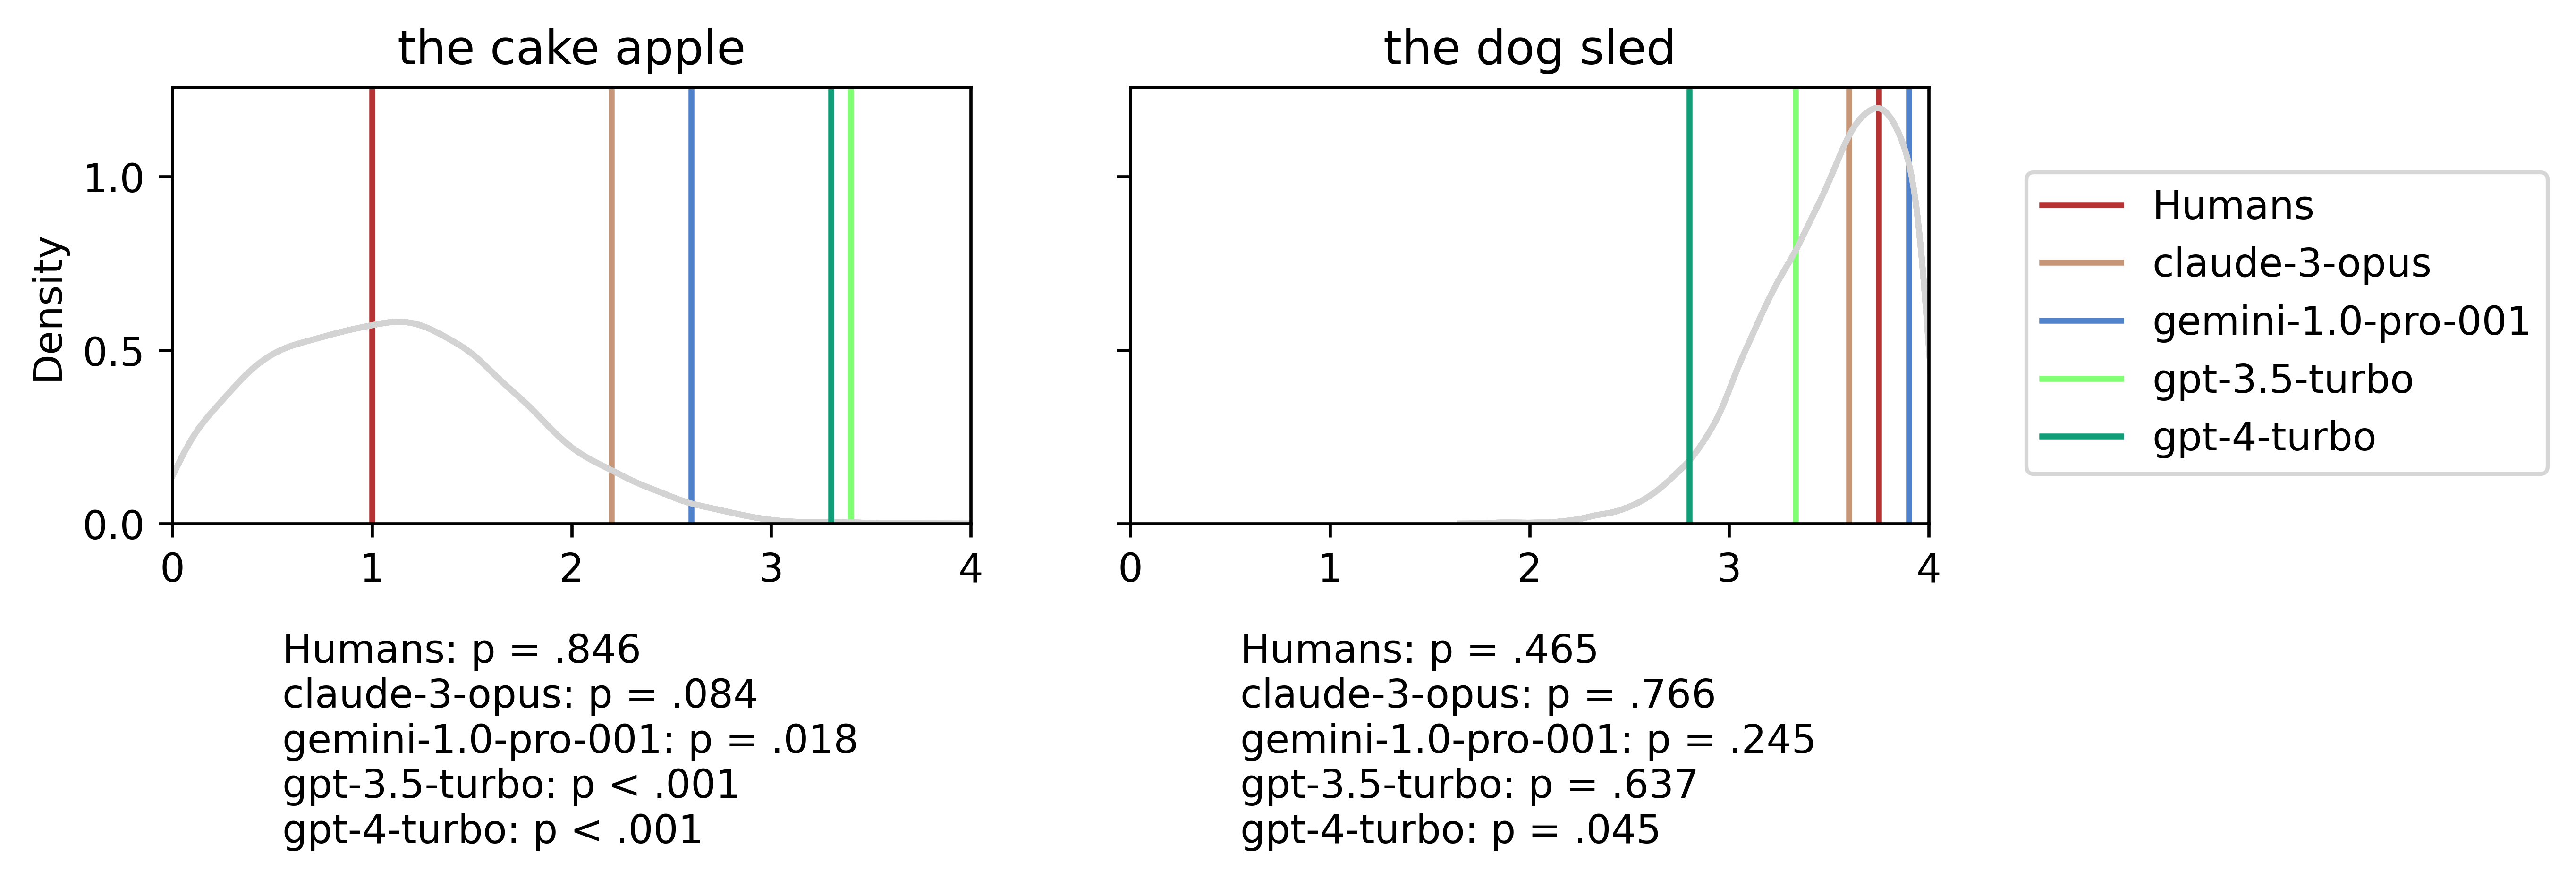

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,2),dpi=600,sharey=True)
for i,phrase in enumerate(['the cake apple','the dog sled']):
    row = df_data.loc[df_data.Stim==phrase]
    legend_handles = []
    for j, row_model in df_models.iterrows():   
        tval,degfree,pval = CrawfordTest(row[row_model['model']].values, row['Simulated Distribution'].values[0])
        sns.kdeplot(row['Simulated Distribution'].values[0],color='lightgray',ax=axes[i])
        axes[i].axvline(x=row[row_model['model']].values[0], color=row_model['color'])
        axes[i].set_title((f"{row['Stim'].values[0]}"))
        axes[i].set(xlim=[0,4])
        
        if pval[0]<.001:
            
            sig = f"p < .001"
        else:
            sig = f"p = {str(round(pval[0],3))[1:]}"
        axes[i].text(x=0.55,y=-0.4-j*0.13,s=f"{row_model['label']}: {sig}")
        legend_handles.append(plt.Line2D([0], [0], 
                                         color=row_model['color'], label=row_model['label']))  
 
axes[1].legend(handles=legend_handles, loc='upper right',bbox_to_anchor=(1.8, 0.85))


fig.savefig(os.path.join(Dir_project,'results','figures','Fig2.jpg'),bbox_inches='tight')

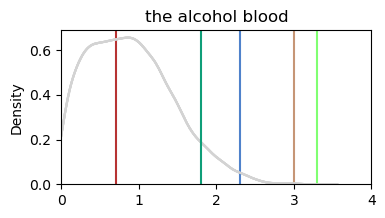

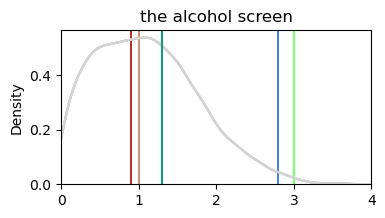

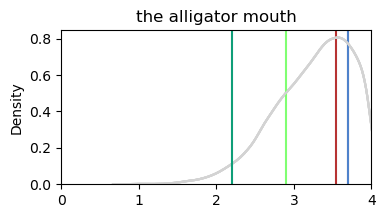

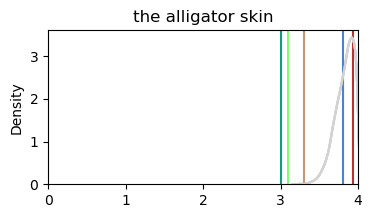

/tmp/ipykernel_287483/494772009.py:49: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(row['Simulated Distribution'],color='lightgray',ax=axes)
/tmp/ipykernel_287483/494772009.py:49: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(row['Simulated Distribution'],color='lightgray',ax=axes)
/tmp/ipykernel_287483/494772009.py:49: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(row['Simulated Distribution'],color='lightgray',ax=axes)
/tmp/ipykernel_287483/494772009.py:49: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(row['Simulated Distribution'],color='lightgray',ax=axes)
/tmp/ipykernel_287483/494772009.py:49: UserWarning: Dataset has 0 variance; skipping density est

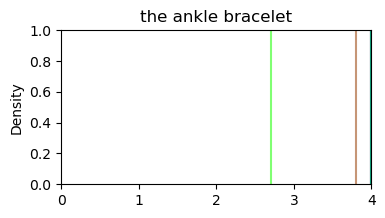

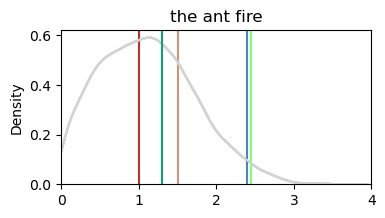

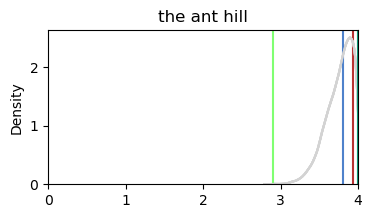

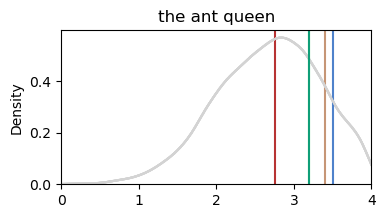

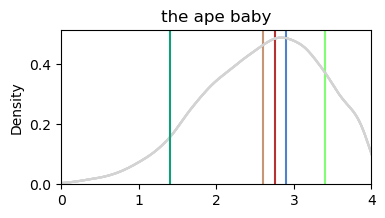

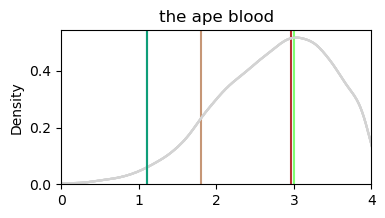

{'Humans Continuous': 0, 'claude_continuous': 331, 'gemini_continuous': 648, 'gpt-3.5-0125_continuous': 974, 'gpt-4-0125_continuous': 515}


In [29]:
model_counts = CompareToSimulatedDist(df_data, df_models)

In [30]:
df_counts = pd.DataFrame(model_counts,index=[0]).T
df_counts = df_counts.reset_index()
df_counts.columns = ['model','counts']
df_counts = df_counts.loc[~df_counts.model.str.contains('Humans')]
df_counts['label'] = ['claude-3-opus','gemini-1.0-pro-001','gpt-3.5-turbo','gpt-4-turbo']
df_counts

,model,counts,label
1,claude_continuous,331,claude-3-opus
2,gemini_continuous,648,gemini-1.0-pro-001
3,gpt-3.5-0125_continuous,974,gpt-3.5-turbo
4,gpt-4-0125_continuous,515,gpt-4-turbo


In [223]:
""" Generate Sampling Distributions of 'Control' data

WARNING: This function can take over 10 minutes to run - consider using concurrent.features or similar parallelization process

For simulated data and permuted data, generate a bootstrapped distribution of outlier responses if randomly sampled N times.

The simulated outlier distribution shows expected probability distribution of the # of outlier responses
N humans would generate

The permuted outlier distribution shows expected probability of the # of outlier responses N responders would generate if
they are allowed to randomly guess responses while knowing the underlying probabilities of each 0-4 response (e.g., 
in original graves dataset, 7% of phrases had a mean rating of 0, 38% had a mean rating of 1, etc.)

"""

def ControlTests(df,N=1000,p_value=0.05):
    sim_outliers = {}
    distributions = ['Simulated Distribution', 'Permuted Distribution']
    print('WARNING: This will likely take 10-20 minutes')

    for dist in distributions:
        sim_outliers[dist] = []

        for i in range(0,N):
            outlier_count = 0

            for index, row in df.iterrows():
                case = np.random.choice(row[dist])

                tval,degfree,pval  = CrawfordTest(case, row['Simulated Distribution'])

                if pval < p_value:
                    outlier_count += 1
                else:
                    pass

            sim_outliers[dist].append(outlier_count) 

    return(sim_outliers)       

In [386]:
control_counts = ControlTests(df_data)

KeyboardInterrupt: 

In [271]:
df_control_counts = pd.DataFrame(control_counts)
df_control_counts.to_csv('/work/desai-lab/xuanyang/Project/TwoWordTest/results/continuous/control_counts_1000bootstrop.csv',index=False)

In [35]:
# load if the data has already been generated
df_control_counts = pd.read_csv('/work/desai-lab/xuanyang/Project/TwoWordTest/results/continuous/control_counts_1000bootstrop.csv')
df_control_counts

,Simulated Distribution,Permuted Distribution
0,52,820
1,63,766
2,49,775
3,62,769
4,55,785
...,...,...
995,64,772
996,60,786
997,47,731
998,51,804


T-test p_value: claude-3-opus vs. Simulated Distribution 0.0
T-test p_value: claude-3-opus vs. Permuted Distribution 0.0
claude-3-opus vs. Simulated and Permuted
T-test p_value: gemini-1.0-pro-001 vs. Simulated Distribution 0.0
T-test p_value: gemini-1.0-pro-001 vs. Permuted Distribution 2.2657431486550195e-11
gemini-1.0-pro-001 vs. Simulated and Permuted
T-test p_value: gpt-3.5-turbo vs. Simulated Distribution 0.0
T-test p_value: gpt-3.5-turbo vs. Permuted Distribution 0.0
gpt-3.5-turbo vs. Simulated and Permuted
T-test p_value: gpt-4-turbo vs. Simulated Distribution 0.0
T-test p_value: gpt-4-turbo vs. Permuted Distribution 0.0
gpt-4-turbo vs. Simulated and Permuted


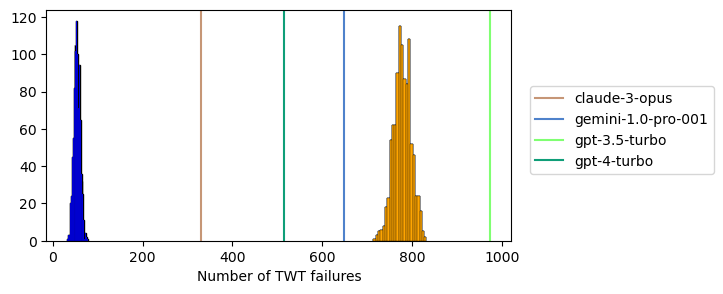

In [36]:
def PlotOutlierCounts(df_counts,control_counts,df_models):
    
    fig, ax = plt.subplots(1,1, figsize=(6,3))
    legend_handles = []
    for i,row in df_counts.iterrows():
        
        sns.histplot(control_counts['Simulated Distribution'], color='blue',ax=ax)
        sns.histplot(control_counts['Permuted Distribution'],color='orange',ax=ax)
        
        ax.axvline(x=row['counts'], color=df_models.loc[df_models.model==row['model'],'color'].values[0])
        
        legend_handles.append(plt.Line2D([0], [0], color=df_models.loc[df_models.model==row['model'],'color'].values[0],
                                         label=row['label']))  
        ax.set(xlabel='Number of TWT failures',ylabel=None)

        for dist in ['Simulated Distribution', 'Permuted Distribution']:
            tval,degfree,pval = CrawfordTest(row['counts'], control_counts[dist])
            
            print('T-test p_value: ' + row['label'] + ' vs. ' + dist, pval)
        
        print(row['label'] + ' vs. Simulated and Permuted')
    ax.legend(handles=legend_handles, loc='upper right',bbox_to_anchor=(1.45, 0.7))
    plt.show()
    fig.savefig(os.path.join(Dir_project,'results','figures','Fig3.jpg'),bbox_inches='tight')
PlotOutlierCounts(df_counts,df_control_counts,df_models)

# Discrete Rating

In [37]:
df_models

,model,label,color,alpha
0,Humans Continuous,Humans,#B73333,0.6
1,claude_continuous,claude-3-opus,#C69676,0.6
2,gemini_continuous,gemini-1.0-pro-001,#4F82CB,0.6
3,gpt-3.5-0125_continuous,gpt-3.5-turbo,#80FF72,0.8
4,gpt-4-0125_continuous,gpt-4-turbo,#0F9E78,0.6


In [41]:
"""
The discrete judgments across the 10 iterations became a probability score ranging from 0 to 1.
We recoded it into a binary score, 'Make Sense' or 'Nonsense'.

"""

def recode_discrete(df,List_models):
    for model in List_models:
        df[f'{model}_b'] = 'Nonsense'
        df.loc[df[model]>=0.5,f'{model}_b'] = 'Makes Sense'
    
    return df
df_data = recode_discrete(df_data,[x for x in df_data.columns if 'discrete' in x and 'Humans' not in x])
df_data

,Stim,Humans Continuous,SD,Word2Vec,GloVe,Taxonomic,Bard,Bard 0 or 1,Bard Continuous,GPT-3.5,...,gpt-4-1106_continuous,gpt-4-1106_discrete,Humans_discrete,sensible,claude_discrete_b,gemini_discrete_b,gpt-3.5-0125_discrete_b,gpt-3.5-1106_discrete_b,gpt-4-0125_discrete_b,gpt-4-1106_discrete_b
0,the alcohol blood,0.71,0.98,0.371276,0.402202,0.570252,Nonsense,0,2,Nonsense,...,2.5,0.5,Nonsense,0.0,Makes Sense,Nonsense,Makes Sense,Makes Sense,Makes Sense,Makes Sense
1,the alcohol screen,0.90,1.18,0.066408,0.079153,0.174365,Nonsense,0,1,Makes Sense,...,1.2,0.1,Nonsense,0.0,Nonsense,Makes Sense,Makes Sense,Makes Sense,Nonsense,Nonsense
2,the alligator mouth,3.54,0.96,0.212631,0.283078,0.205588,Makes Sense,1,2,Nonsense,...,2.5,0.8,Makes Sense,1.0,Makes Sense,Makes Sense,Makes Sense,Makes Sense,Makes Sense,Makes Sense
3,the alligator skin,3.93,0.26,0.150999,0.284452,0.227702,Nonsense,0,3,Makes Sense,...,3.3,1.0,Makes Sense,1.0,Makes Sense,Makes Sense,Makes Sense,Makes Sense,Makes Sense,Makes Sense
4,the ankle bracelet,4.00,0.00,0.158441,0.392702,0.263679,Nonsense,0,3,Makes Sense,...,3.9,1.0,Makes Sense,1.0,Makes Sense,Makes Sense,Makes Sense,Makes Sense,Makes Sense,Makes Sense
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1763,the woman judge,3.64,0.78,0.279547,0.290409,0.280588,Makes Sense,1,4,Makes Sense,...,4.0,1.0,Makes Sense,1.0,Makes Sense,Makes Sense,Makes Sense,Makes Sense,Makes Sense,Makes Sense
1764,the woman mountain,0.43,0.74,0.117146,0.187664,0.175159,Nonsense,0,3,Nonsense,...,1.5,0.0,Nonsense,0.0,Nonsense,Nonsense,Makes Sense,Makes Sense,Nonsense,Nonsense
1765,the worm farmer,2.50,1.62,0.118636,0.056309,0.270838,Nonsense,0,2,Makes Sense,...,1.6,0.1,Makes Sense,1.0,Nonsense,Makes Sense,Makes Sense,Makes Sense,Makes Sense,Nonsense
1766,the yarn ball,3.59,0.98,0.093765,0.204294,0.390770,Nonsense,0,3,Makes Sense,...,4.0,1.0,Makes Sense,1.0,Makes Sense,Makes Sense,Makes Sense,Makes Sense,Makes Sense,Makes Sense


In [42]:
""" Chi Squared Test

Run Chi Squared Test which compares the expected frequency of responses (human), to the observed (LLMs)

NOTE: a non-significant Chi Squared does not necessarily mean that the LLM is correctly classifying phrases,
it only means that the frequency of responses of the LLM closely matches humans
"""

def ChiSquareLoop(df, models_list):
    fexp = df['Humans_discrete'].value_counts()
    
    for model in models_list:
        fobs = df[model].value_counts()
        
        chi = stats.chisquare(f_obs=[fobs[0], fobs[1]], f_exp=[fexp[0],fexp[1]])
        
        print('Results for ', model)
        print(fobs)
        print(chi)
        print(f"X2={round(chi[0],1)}, p={round(chi[1],4)}")
        print('################')


In [43]:
ChiSquareLoop(df_data, [x for x in df_data.columns if 'discrete_b' in x])

Results for  claude_discrete_b
claude_discrete_b
Makes Sense    1041
Nonsense        727
Name: count, dtype: int64
Power_divergenceResult(statistic=9.370681166190266, pvalue=0.0022048357134971668)
X2=9.4, p=0.0022
################
Results for  gemini_discrete_b
gemini_discrete_b
Makes Sense    1172
Nonsense        596
Name: count, dtype: int64
Power_divergenceResult(statistic=86.9922244493127, pvalue=1.0894866772027467e-20)
X2=87.0, p=0.0
################
Results for  gpt-3.5-0125_discrete_b
gpt-3.5-0125_discrete_b
Makes Sense    1766
Nonsense          2
Name: count, dtype: int64
Power_divergenceResult(statistic=1424.1811060200025, pvalue=1.1691096735925e-311)
X2=1424.2, p=0.0
################
Results for  gpt-3.5-1106_discrete_b
gpt-3.5-1106_discrete_b
Makes Sense    1767
Nonsense          1
Name: count, dtype: int64
Power_divergenceResult(statistic=1427.793485307457, pvalue=0.0)
X2=1427.8, p=0.0
################
Results for  gpt-4-0125_discrete_b
gpt-4-0125_discrete_b
Makes Sense    

In [44]:
""" Signal Detection Theory 

Function that calculates various SDT metrics we will use later
"""

def SDT(hits, misses, fas, crs):
    """ returns a dict with d-prime measures given hits, misses, false alarms, and correct rejections"""
    # Floors an ceilings are replaced by half hits and half FA's
    half_hit = 0.5 / (hits + misses)
    half_fa = 0.5 / (fas + crs)
     # Calculate hit_rate and avoid d' infinity
    hit_rate = hits / (hits + misses)
    if hit_rate == 1: 
        hit_rate = 1 - half_hit
    if hit_rate == 0: 
        hit_rate = half_hit
 
    # Calculate false alarm rate and avoid d' infinity
    fa_rate = fas / (fas + crs)
    if fa_rate == 1: 
        fa_rate = 1 - half_fa
    if fa_rate == 0: 
        fa_rate = half_fa
        
    #transform betaBard Continuous to base 10 log of beta
    beta = math.exp((Z(fa_rate)**2 - Z(hit_rate)**2) / 2)
    beta = math.log10(beta)
 
    # Return d', beta, c and Ad'
    out = {}
    out['d'] = Z(hit_rate) - Z(fa_rate)
    out['beta'] = beta
    out['c'] = -(Z(hit_rate) + Z(fa_rate)) / 2
    out['Ad'] = stats.norm.cdf(out['d'] / math.sqrt(2))
    
    return(out)

In [45]:
""" SDT, Part 2

Calculate SDT metrics on your models, output counts, graphs, and metrics (e.g., D prime)
"""

def RunSDT(df, models_list):
    dfs = []
    for model in models_list:
        answer_type = [
            (df[model] == 'Makes Sense') & (df['Humans_discrete'] == 'Nonsense'),
            (df[model] == 'Nonsense') & (df['Humans_discrete'] == 'Makes Sense'),
            (df[model] == 'Makes Sense') & (df['Humans_discrete'] == 'Makes Sense'),
            (df[model] == 'Nonsense') & (df['Humans_discrete'] == 'Nonsense')
        ]
        
        answer_names = ['False Alarm', 'Miss', 'Hit', 'Correct Rejection']

        new_col = model + ' Answer Type'
        
        df[new_col] = np.select(answer_type, answer_names)
        
        df_tmp = pd.DataFrame(df[new_col].value_counts()).T.reset_index(drop=True)
        for i in answer_names:
            if i not in df_tmp.columns:
                df_tmp[i] = 0
        df_tmp['model']=model
        dfs.append(df_tmp)
        fas, misses, hits, crs = [df_tmp[answer_names[i]].values[0] for i in range(len(answer_names))]
        
        SDT_result = SDT(hits, misses, fas, crs)
        
        print(model)
        print('Hits: ', hits)
        print('Misses: ', misses)
        print('False Alarms: ', fas)
        print('Correct Rejections: ', crs)
        print('SDT Results')
        
        k=2
        
        print({key: float(f"{value:.{k}f}") for key, value in SDT_result.items()})

        sns.countplot(data=df, x=df[new_col], order=['Hit', 'Miss','Correct Rejection', 'False Alarm'])
        plt.show()
        
        print('####################')
    dfs = pd.concat(dfs,ignore_index=True)
    return(dfs)

claude_discrete_b
Hits:  726
Misses:  65
False Alarms:  315
Correct Rejections:  662
SDT Results
{'d': 1.85, 'beta': -0.37, 'c': -0.46, 'Ad': 0.9}


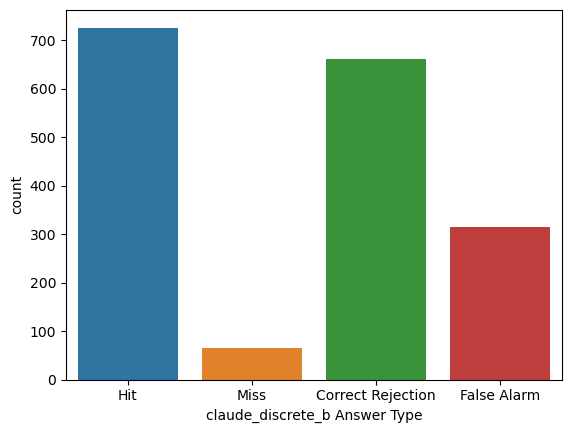

####################
gemini_discrete_b
Hits:  740
Misses:  51
False Alarms:  432
Correct Rejections:  545
SDT Results
{'d': 1.66, 'beta': -0.5, 'c': -0.69, 'Ad': 0.88}


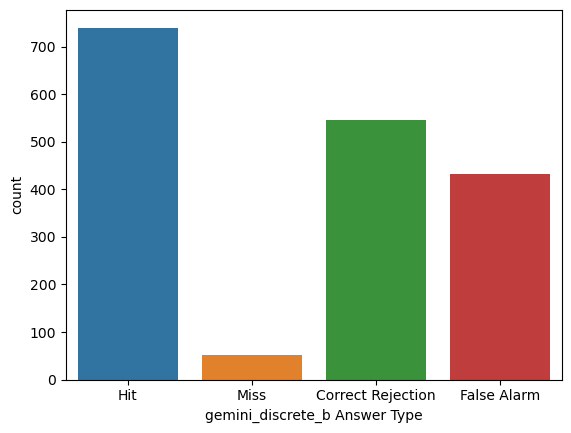

####################
gpt-3.5-0125_discrete_b
Hits:  791
Misses:  0
False Alarms:  975
Correct Rejections:  2
SDT Results
{'d': 0.35, 'beta': -0.47, 'c': -3.05, 'Ad': 0.6}


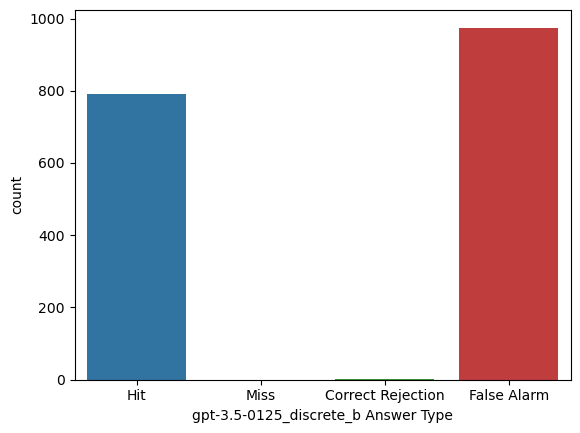

####################
gpt-3.5-1106_discrete_b
Hits:  791
Misses:  0
False Alarms:  976
Correct Rejections:  1
SDT Results
{'d': 0.14, 'beta': -0.19, 'c': -3.15, 'Ad': 0.54}


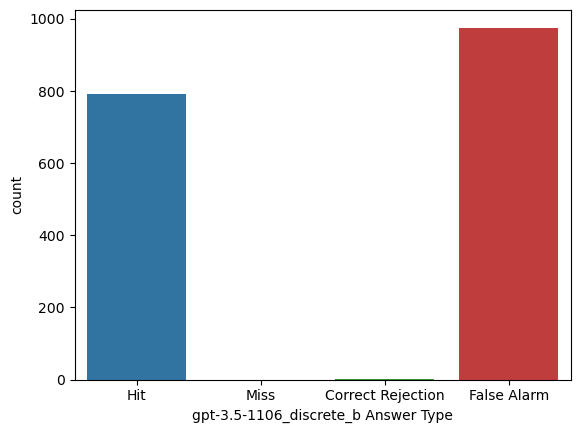

####################
gpt-4-0125_discrete_b
Hits:  692
Misses:  99
False Alarms:  418
Correct Rejections:  559
SDT Results
{'d': 1.33, 'beta': -0.28, 'c': -0.48, 'Ad': 0.83}


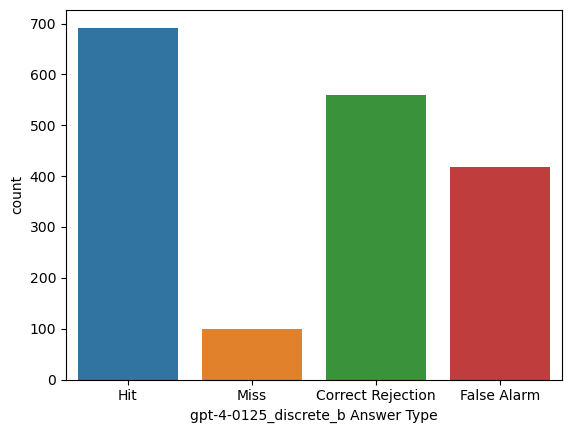

####################
gpt-4-1106_discrete_b
Hits:  656
Misses:  135
False Alarms:  255
Correct Rejections:  722
SDT Results
{'d': 1.59, 'beta': -0.11, 'c': -0.16, 'Ad': 0.87}


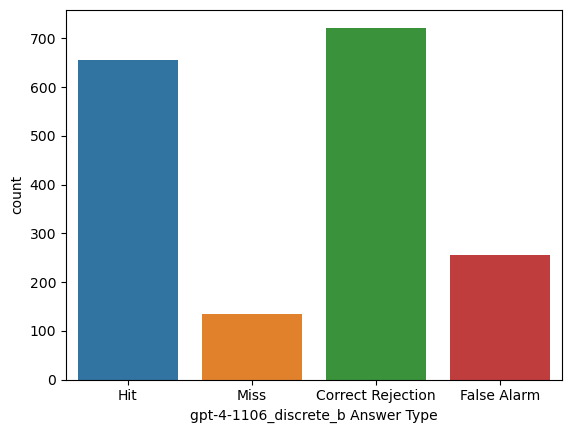

####################


In [46]:
df_SDT = RunSDT(df_data,[x for x in df_data.columns if 'discrete_b' in x])

In [47]:
df_plot = df_SDT.melt(id_vars=['model'])
df_plot['model'] = df_plot['model'].str.replace('_discrete_b','')
df_plot = df_plot.loc[~df_plot.model.str.contains('1106')]
df_plot.model = df_plot.model.map({'claude':'claude-3-opus','gemini':'gemini-1.0-pro-001','gpt-3.5-0125':'gpt-3.5-turbo','gpt-4-0125':'gpt-4-turbo'})
df_models_discrete = df_models.copy()
df_models_discrete['model'] = df_models_discrete['model'].str.replace('_continuous','_discrete_b')
df_models_discrete.loc[df_models_discrete.model=='Humans Continuous','model'] = 'Humans_discrete'
palette = df_models_discrete[['label','color']].set_index('label').to_dict()['color']
df_models_discrete

,model,label,color,alpha
0,Humans_discrete,Humans,#B73333,0.6
1,claude_discrete_b,claude-3-opus,#C69676,0.6
2,gemini_discrete_b,gemini-1.0-pro-001,#4F82CB,0.6
3,gpt-3.5-0125_discrete_b,gpt-3.5-turbo,#80FF72,0.8
4,gpt-4-0125_discrete_b,gpt-4-turbo,#0F9E78,0.6


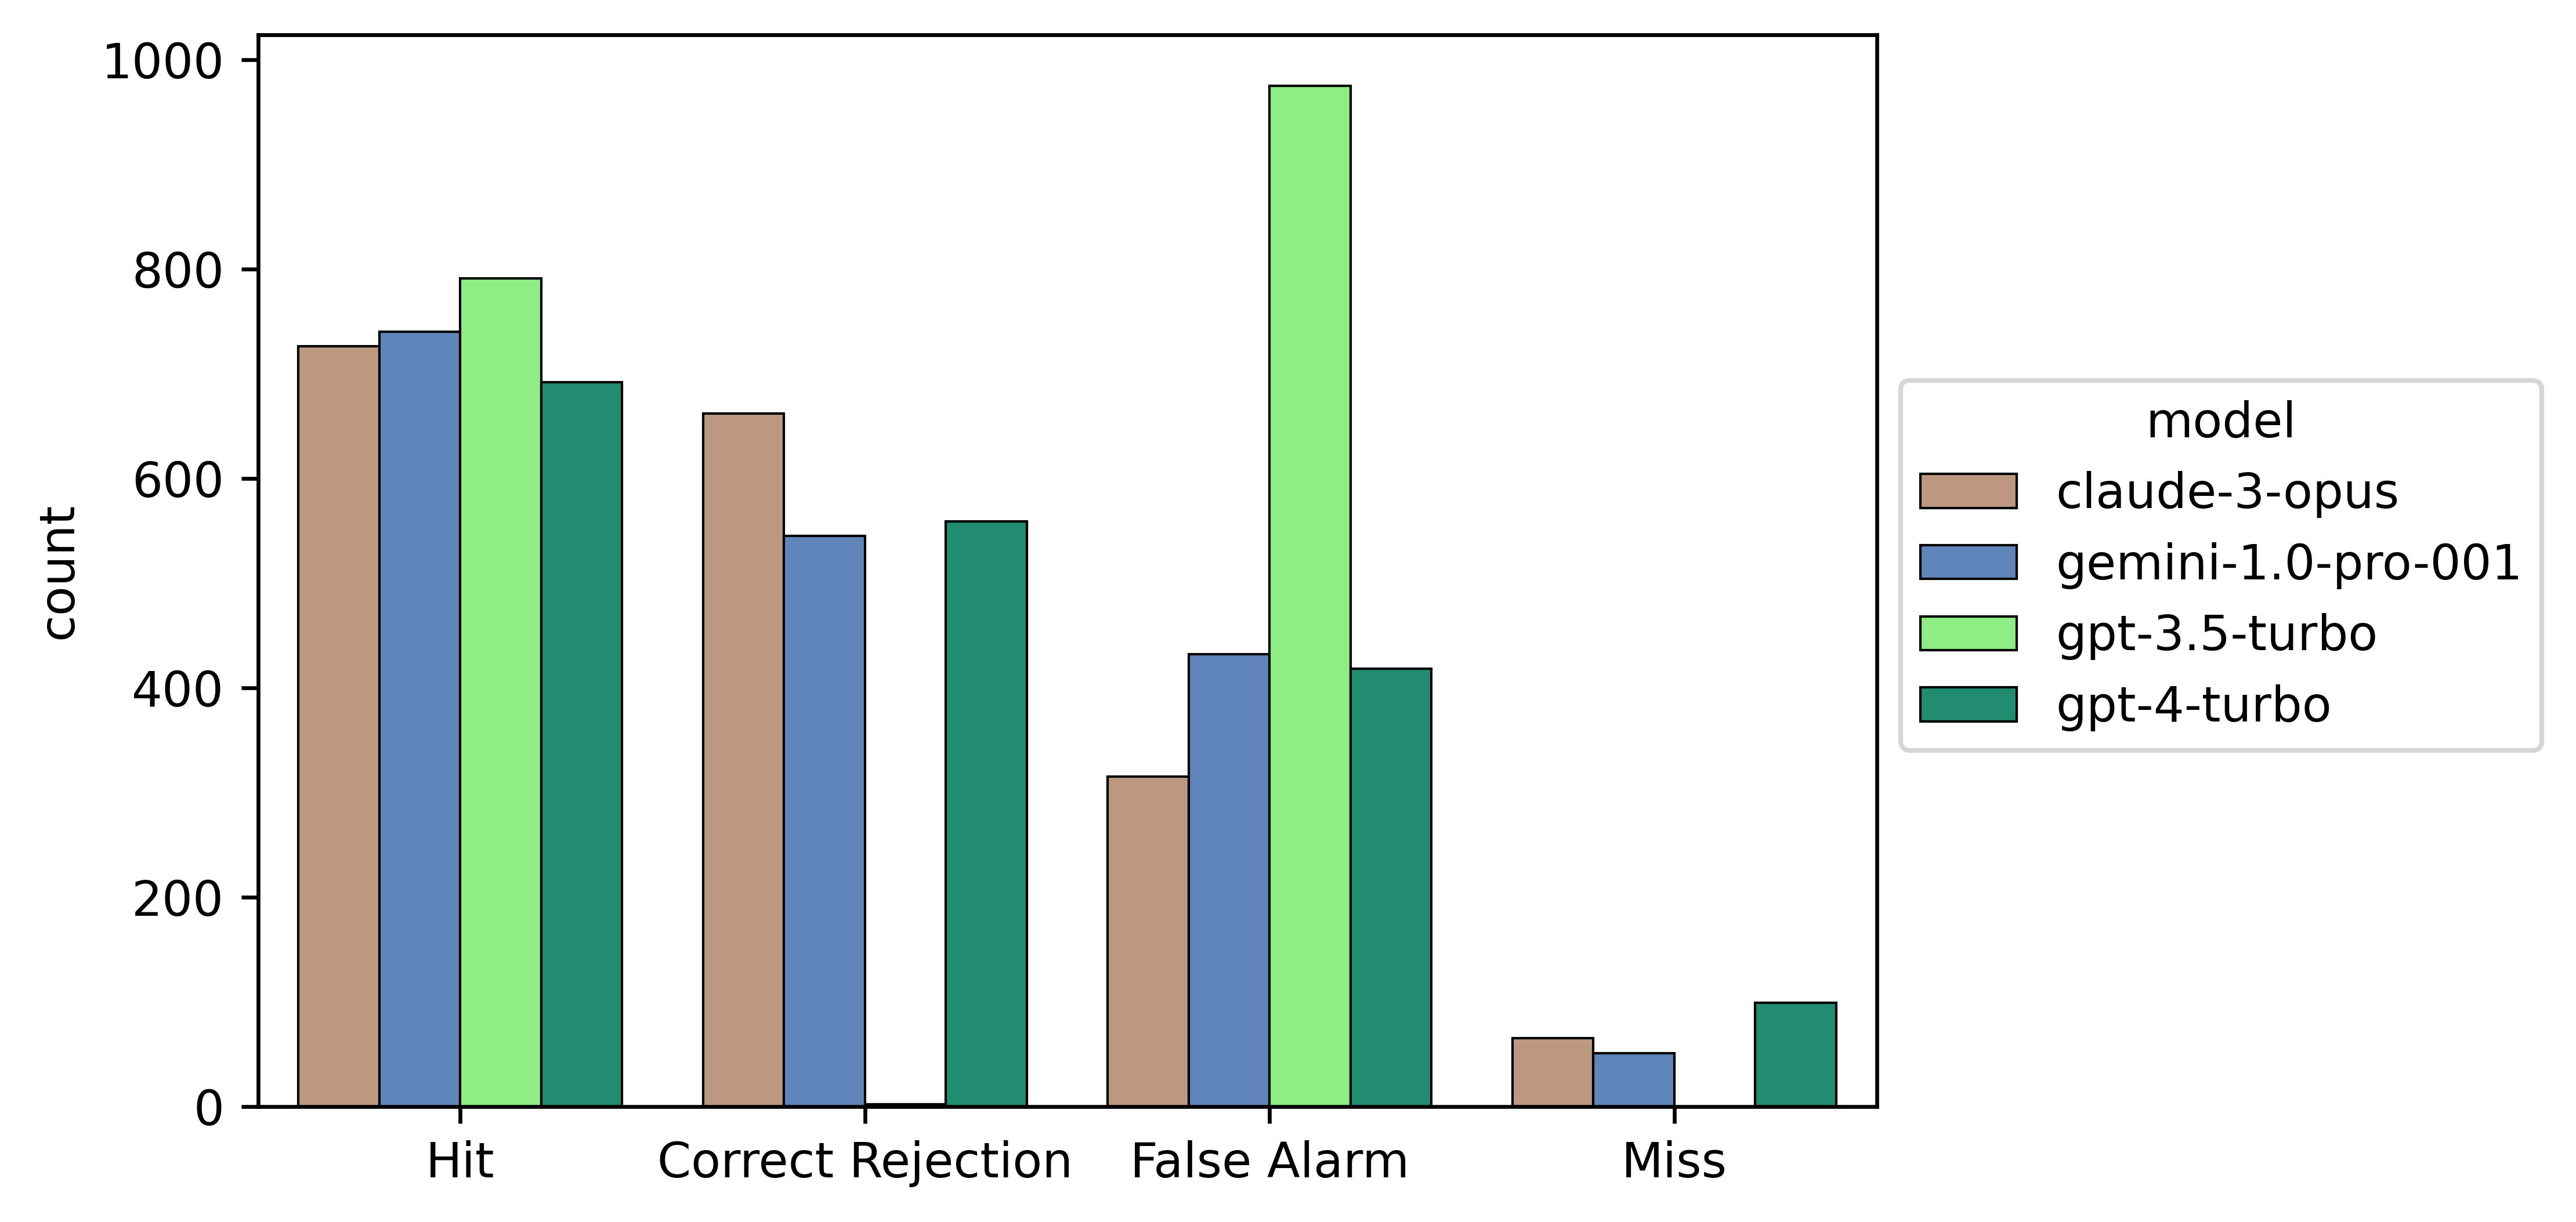

In [48]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(6,4),dpi=600)
sns.barplot(data=df_plot,x='variable',y='value',palette = palette,edgecolor='black',linewidth=0.5,
              hue='model',ax=ax)
ax.set(xlabel=None,ylabel='count')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 0.7))
plt.show()
fig.savefig(os.path.join(Dir_project,'results','figures','Fig4.jpg'),bbox_inches='tight')

In [49]:
""" Reciever Operating Characteristic

Make ROC curve for models, plot them
Output area under the curve

"""

def ROCPlots(df, models_list):

    labels_for_ROC = [0,1]

    human_for_ROC = [
        (df['Humans_discrete'] == 'Nonsense'),
        (df['Humans_discrete'] == 'Makes Sense')
    ]

    truth = np.select(human_for_ROC, labels_for_ROC)
    random = np.random.randint(0,2,size=len(df))

    rand_fpr, rand_tpr, thresholds = roc_curve(truth, random, pos_label=1)

    plt.plot(rand_fpr, rand_tpr, marker='.', label='Random')
    
    for model in models_list:

        LLM_for_ROC = [
            (df[model] == 'Nonsense'),
            (df[model] == 'Makes Sense')
        ]

        predicted = np.select(LLM_for_ROC, labels_for_ROC)

        fpr, tpr, thresholds = roc_curve(truth, predicted, pos_label=1)

        plt.plot(fpr, tpr, marker='.', label = model)
        
        auc = roc_auc_score(truth,predicted)
        
        print(model + ' AUC: ', auc)
    
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

claude_discrete_b AUC:  0.8
gemini_discrete_b AUC:  0.75
gpt-3.5-0125_discrete_b AUC:  0.5
gpt-4-0125_discrete_b AUC:  0.72


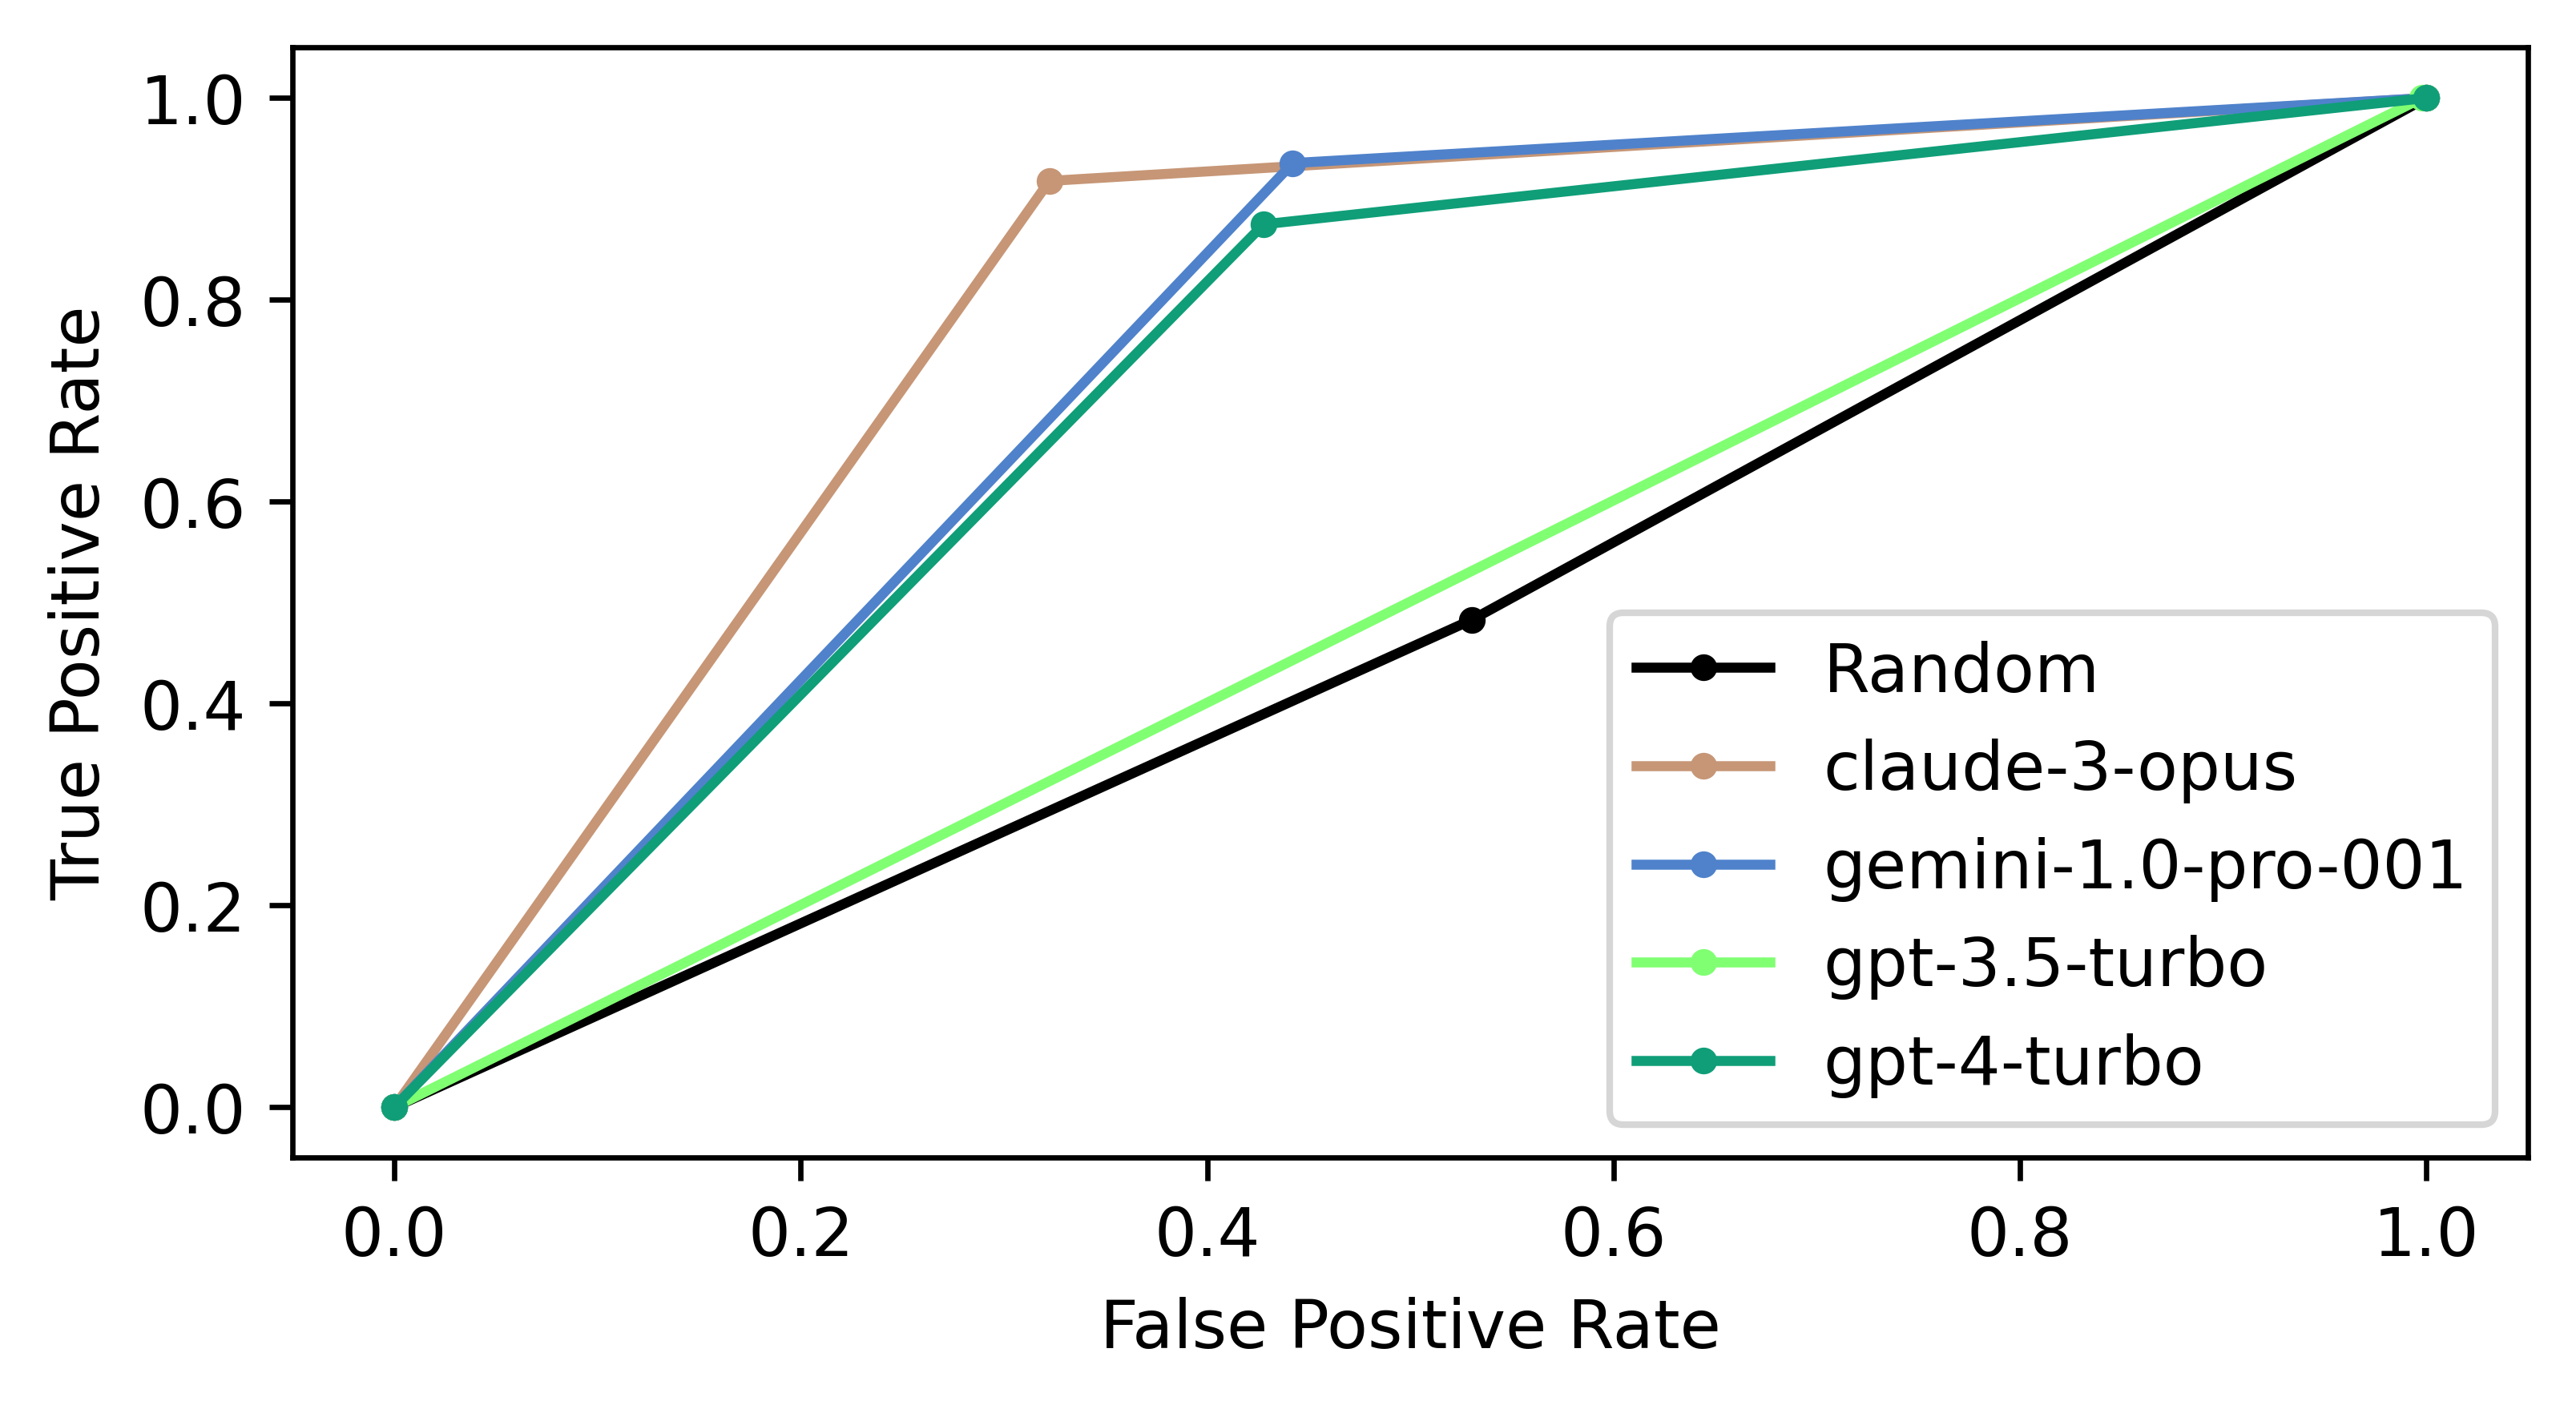

In [50]:
""" Reciever Operating Characteristic

Make ROC curve for models, plot them
Output area under the curve

"""

def ROCPlots(df, df_models):

    df = df_data.copy()
    labels_for_ROC = [0,1]

    human_for_ROC = [
        (df['Humans_discrete'] == 'Nonsense'),
        (df['Humans_discrete'] == 'Makes Sense')
    ]

    truth = np.select(human_for_ROC, labels_for_ROC)
    random = np.random.randint(0,2,size=len(df))

    rand_fpr, rand_tpr, thresholds = roc_curve(truth, random, pos_label=1)
    
    fig,ax = plt.subplots(1,1,figsize=(6,3),dpi=600)
    ax.plot(rand_fpr, rand_tpr, marker='.', label='Random',color='black')

    for i,row in df_models.iterrows():
        model = row['model']
        LLM_for_ROC = [
            (df[model] == 'Nonsense'),
            (df[model] == 'Makes Sense')
        ]

        predicted = np.select(LLM_for_ROC, labels_for_ROC)

        fpr, tpr, thresholds = roc_curve(truth, predicted, pos_label=1)

        ax.plot(fpr, tpr, marker='.', label = row['label'],color=row['color'])

        auc = roc_auc_score(truth,predicted)

        print(model + ' AUC: ', round(auc,2))

    ax.legend()
    ax.set(xlabel='False Positive Rate',ylabel='True Positive Rate')
    plt.show()
    fig.savefig(os.path.join(Dir_project,'results','figures','Fig5.jpg'),bbox_inches='tight')
ROCPlots(df_data, df_models_discrete.loc[~df_models_discrete.model.str.contains('Humans')])